In [1]:
!pip install /kaggle/input/gdal-wheel/GDAL-3.6.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/gdal-wheel/GDAL-3.6.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
!pip install wandb

In [3]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
! wandb login 3d8cd71bba3e3d180da7174e7af95a291e76a8a2

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
import os.path
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from osgeo import gdal
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class UNet(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(input_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.center = self.conv_block(512, 1024)
        self.dec4 = self.conv_block(1024 + 512, 512)
        self.dec3 = self.conv_block(512 + 256, 256)
        self.dec2 = self.conv_block(256 + 128, 128)
        self.dec1 = self.conv_block(128 + 64, 64)
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        center = self.center(self.pool(enc4))

        dec4 = self.dec4(torch.cat([enc4, self.up(center)], 1))
        dec3 = self.dec3(torch.cat([enc3, self.up(dec4)], 1))
        dec2 = self.dec2(torch.cat([enc2, self.up(dec3)], 1))
        dec1 = self.dec1(torch.cat([enc1, self.up(dec2)], 1))
        final = self.final(dec1).squeeze()

        return torch.sigmoid(final)

In [6]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(input, target)  # 计算交叉熵损失
        pt = torch.exp(-ce_loss)  # 计算概率
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss  # 计算Focal Loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [7]:
from torch.utils.data import Dataset
import albumentations as A


class RSDataset(Dataset):
    def __init__(self, data_path, files, transform=None):
        self.data_path = data_path
        self.files = files
        self.transform = transform
        self.images = self.read_multiband_images(data_path, files)
        self.labels = self.read_singleband_labels(data_path, files)

    # 读取多波段图像
    def read_multiband_images(self, data_path, files):
        images = []
        for image_path in files:
            rsdl_data = gdal.Open(os.path.join(data_path, "bigimage", image_path))
            if rsdl_data==None:
                print(os.path.join(data_path, "bigimage", image_path))
                continue
            num_bands = rsdl_data.RasterCount
            image = np.stack([rsdl_data.GetRasterBand(i).ReadAsArray() for i in range(1, num_bands + 1)], axis=0)
            images.append(image)
        return images

    # 读取单波段标签
    def read_singleband_labels(self, data_path, files):
        labels = []
        for label_path in files:
            rsdl_data = gdal.Open(os.path.join(data_path, "bd1203", label_path))
            labels.append(rsdl_data.GetRasterBand(1).ReadAsArray())
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32)
        label = self.labels[idx].astype(np.float32)

        # 确保图像和掩码的尺寸相同
        if image.shape[1:] != label.shape:
            # 使用 albumentations 的 Resize 变换来调整图像和掩码的大小
            resize = A.Resize(height=label.shape[0], width=label.shape[1])
            augmented = resize(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        # 应用数据增强
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']
        else:
            image = torch.tensor(image)
            label = torch.tensor(label)

        return image, label

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# import torch


# class Metrics:
#     def __init__(self, class_num, device='cpu'):
#         self.class_num = class_num
#         self.device = device
#         self.cfm = self.cfm_init(self.class_num)
        
#     def cfm_init(self, class_num):
#         return torch.zeros(size=(class_num, class_num), dtype=torch.int).to(self.device)
    
#     def update(self):
#         self.cfm = self.cfm_init(self.class_num)
    
#     def sample_add(self, true_vector, pre_vector):
#         true_vector = true_vector.flatten().long()
#         pre_vector = pre_vector.flatten().round().long()
        
#         mask = (true_vector >= 0) & (true_vector < self.class_num)
#         self.cfm += torch.bincount(self.class_num * true_vector[mask] + pre_vector[mask],
#                                 minlength=self.class_num ** 2).reshape(self.class_num, self.class_num).to(self.device)
    
#     def acc(self):
#         per_class_acc = torch.diag(self.cfm).float() / torch.sum(self.cfm, dim=1).float()
#         total_acc = torch.diag(self.cfm).sum().float() / self.cfm.sum().float()
#         return per_class_acc, total_acc
    
#     def iou(self):
#         per_class_iou = torch.diag(self.cfm).float() / (
#                     torch.sum(self.cfm, dim=1).float() + torch.sum(self.cfm, dim=0).float() - torch.diag(
#                 self.cfm).float())
#         total_iou = torch.diag(self.cfm).sum().float() / (
#                     torch.sum(self.cfm).float() + torch.sum(self.cfm).float() - torch.diag(self.cfm).sum().float())
#         return per_class_iou, total_iou
    
#     def precision(self):
#         per_class_precision = torch.diag(self.cfm).float() / torch.sum(self.cfm, dim=0).float()
#         total_precision = torch.diag(self.cfm).sum().float() / torch.sum(self.cfm, dim=0).sum().float()
#         return per_class_precision, total_precision
    
#     def recall(self):
#         per_class_recall = torch.diag(self.cfm).float() / torch.sum(self.cfm, dim=1).float()
#         total_recall = torch.diag(self.cfm).sum().float() / torch.sum(self.cfm, dim=1).sum().float()
#         return per_class_recall, total_recall
    
#     def compute(self):
#         acc = self.acc()
#         iou = self.iou()
#         precision = self.precision()
#         recall = self.recall()
        
#         results = {
#             'acc': acc[0].tolist(),  # 每类的准确率
#             'total_acc': acc[1].item(),  # 总体准确率
#             'iou': iou[0].tolist(),  # 每类的 IoU
#             'total_iou': iou[1].item(),  # 总体 IoU
#             'precision': precision[0].tolist(),  # 每类的精确率
#             'total_precision': precision[1].item(),  # 总体精确率
#             'recall': recall[0].tolist(),  # 每类的召回率
#             'total_recall': recall[1].item()  # 总体召回率
#         }
        
#         return results
    
# # if __name__ == '__main__':
# #     class_num = 3
# #     metrics = Metrics(class_num)
    
# #     true_vectors = torch.tensor([0, 1.9, 2, 1, 0, 2, 2, 1, 0, 1])
# #     pred_vectors = torch.tensor([0, 2, 2, 1, 0, 2, 0, 1, 1, 1])
    
# #     # 将这些样本添加到混淆矩阵中
# #     metrics.sample_add(true_vectors, pred_vectors)
    
# #     results = metrics.compute()
    
# #     print("评估指标:")
# #     for key, value in results.items():
# #         print(f"{key}: {value}")

In [9]:
class Metrics:
    def __init__(self, threshold=0.5, eps=1e-7):
        """
        初始化二分类分割指标计算类。
        :param threshold: 阈值，用于将概率图转换为离散标签（默认0.5）。
        :param eps: 一个小的常量，防止除零错误。
        """
        self.threshold = threshold
        self.eps = eps

    def to_binary(self, prediction):
        """
        将模型输出转换为二分类标签（0或1）。
        :param prediction: 模型输出的概率图。
        :return: 离散化后的标签。
        """
        return (prediction >= self.threshold).float()

    def dice_coefficient(self, prediction, target):
        """
        计算Dice系数。
        :param prediction: 预测结果的概率图。
        :param target: 真实标签。
        :return: Dice系数。
        """
        prediction = self.to_binary(prediction)
        target = target.float()

        intersection = (prediction * target).sum()
        dice = (2. * intersection + self.eps) / (prediction.sum() + target.sum() + self.eps)
        return dice

    def iou(self, prediction, target):
        """
        计算IoU（交并比）。
        :param prediction: 预测结果的概率图。
        :param target: 真实标签。
        :return: IoU值。
        """
        prediction = self.to_binary(prediction)
        target = target.float()

        intersection = (prediction * target).sum()
        union = prediction.sum() + target.sum() - intersection
        iou = (intersection + self.eps) / (union + self.eps)
        return iou

    def precision(self, prediction, target):
        """
        计算精确率（Precision）。
        :param prediction: 预测结果的概率图。
        :param target: 真实标签。
        :return: 精确率值。
        """
        prediction = self.to_binary(prediction)
        target = target.float()

        true_positive = (prediction * target).sum()
        predicted_positive = prediction.sum()
        precision = (true_positive + self.eps) / (predicted_positive + self.eps)
        return precision

    def recall(self, prediction, target):
        """
        计算召回率（Recall）。
        :param prediction: 预测结果的概率图。
        :param target: 真实标签。
        :return: 召回率值。
        """
        prediction = self.to_binary(prediction)
        target = target.float()

        true_positive = (prediction * target).sum()
        actual_positive = target.sum()
        recall = (true_positive + self.eps) / (actual_positive + self.eps)
        return recall

    def compute(self, prediction, target):
        """
        计算所有的评价指标。
        :param prediction: 预测结果的概率图。
        :param target: 真实标签。
        :return: 包含所有指标的字典。
        """
        dice = self.dice_coefficient(prediction, target).item()
        iou = self.iou(prediction, target).item()
        precision = self.precision(prediction, target).item()
        recall = self.recall(prediction, target).item()

        return {
            'Dice Coefficient': dice,
            'IoU': iou,
            'Precision': precision,
            'Recall': recall
        }


In [10]:
import os
import matplotlib.pyplot as plt

def plot_images(labels, outputs, epoch, batch_idx, output_dir='/kaggle/working/train_images'):
    # 创建输出目录（如果不存在）
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 准备绘图
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # 将标签图像显示为黑白
    axs[0].imshow(labels[0].cpu().numpy(), cmap='gray')  # 'gray' 表示黑白映射
    axs[0].set_title("Ground Truth")
    axs[0].axis('off')

    # 将模型输出图像显示为黑白
    axs[1].imshow(outputs[0].cpu().detach().numpy(), cmap='gray')  # 'gray' 表示黑白映射
    axs[1].set_title("Model Output")
    axs[1].axis('off')

    # 设置标题
    plt.suptitle(f'Epoch {epoch + 1}, Batch {batch_idx + 1}')

    # 保存图像到文件夹
    output_path = os.path.join(output_dir, f'epoch_{epoch + 1}_batch_{batch_idx + 1}.png')
    plt.savefig(output_path)
    plt.close(fig)

In [11]:
# def validate(model, val_loader, criterion, device,metrics):
#     model.eval()  # 设置模型为评估模式
#     val_loss = 0.0
#     # metrics = Metrics(class_num=2, device=device)  # 创建新的度量指标对象

#     with torch.no_grad():
#         for images, labels in val_loader:
#             images = images.float().to(device)
#             labels = labels.float().to(device)

#             # 模型预测
#             outputs = model(images)

#             # 计算验证集的损失
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#             # 将模型输出转换为二值图
#             pred_binary = torch.round(outputs)

#             # 更新混淆矩阵
#             metrics.sample_add(labels, pred_binary)

#     # 计算平均验证损失
#     val_loss /= len(val_loader)

#     # 计算评估指标
#     val_metrics = metrics.compute()

#     return val_loss, val_metrics
def validate(model, val_loader, criterion, device,metrics):
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0
    # metrics = Metrics(class_num=2, device=device)  # 创建新的度量指标对象

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.float().to(device)
            labels = labels.float().to(device)

            # 模型预测
            outputs = model(images)

            # 计算验证集的损失
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 将模型输出转换为二值图
            pred_binary = torch.round(outputs)

            # 更新混淆矩阵
            # metrics.sample_add(labels, pred_binary)

    # 计算平均验证损失
    val_loss /= len(val_loader)

    # 计算评估指标
    val_metrics = metrics.compute(labels,outputs)

    return val_loss, val_metrics

In [12]:
import os.path
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from osgeo import gdal
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
# from net.Unet import UNet
# from utils.FocalLoss import FocalLoss
# from utils.metrics import Metrics
# from utils.RSDataset import RSDataset
from sklearn.model_selection import train_test_split
# from utils.sava_images import plot_images
# from utils.validate import validate
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 指定图像和标签文件的路径
data_path = r"/kaggle/input/mydata-argument/MyDada"
txt_file = r'/kaggle/input/mydata-spilt/trainVal.txt'
CLASS_NUM=2
IN_CHANNELS=11
NUM_EPOCH = 400
BATCH_SIZE=32
LR=0.0001



# 读取文件路径
with open(os.path.join(data_path, txt_file), 'r') as f:
    all_files = f.readlines()
all_files = [file.strip() for file in all_files]

# 划分训练集和验证集
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)


# 创建训练和验证数据集加载器
train_dataset = RSDataset(data_path, train_files)
val_dataset = RSDataset(data_path, val_files)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(IN_CHANNELS, 1).to(device)  # 将模型移动到GPU
criterion = nn.BCELoss()
# criterion = FocalLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_loss_list = []
val_loss_list = []
# metrics = Metrics(class_num=2, device=device)  # 二分类问题
metrics = Metrics()
# 用于存储最新的5个模型的文件路径
recent_model_files = []
# 用于保存最好的模型
best_val_loss = float('inf')

# 确保模型保存的目录存在
model_dir = '/kaggle/working/models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

with open('loss_data.txt', 'w') as f:
    for epoch in range(NUM_EPOCH):
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.float().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                plot_images(labels, (outputs>0.5).long(), epoch, batch_idx)

        val_loss, val_metrics = validate(model, val_loader, criterion, device, metrics)
        print(f'Epoch [{epoch + 1}/{NUM_EPOCH}], Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')
#         print(f"Validation Metrics: Accuracy={val_metrics['total_acc']:.4f}, IoU={val_metrics['total_iou']:.4f}, "
#               f"Precision={val_metrics['total_precision']:.4f}, Recall={val_metrics['total_recall']:.4f}")
        print(f"Validation Metrics: Dice Coefficient={val_metrics['Dice Coefficient']:.4f}, IoU={val_metrics['IoU']:.4f}, "
              f"Precision={val_metrics['Precision']:.4f}, Recall={val_metrics['Recall']:.4f}")
        train_loss_list.append(loss.item())
        val_loss_list.append(val_loss)

        f.write(f'{loss.item()}\t{val_loss}\n')

        # 保存模型
        model_path = os.path.join(model_dir, f'model_{epoch}.pth')
        torch.save(model.state_dict(), model_path)
        recent_model_files.append(model_path)

        # 只保留最新的5个模型文件
        if len(recent_model_files) > 5:
            oldest_model = recent_model_files.pop(0)
            if os.path.exists(oldest_model):
                os.remove(oldest_model)

        # 保存验证集上最好的模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(model_dir, 'best_model.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")

Epoch [1/400], Loss: 0.7273, Validation Loss: 0.7281
Validation Metrics: Dice Coefficient=0.1052, IoU=0.0555, Precision=0.4917, Recall=0.0589
Best model saved with validation loss: 0.7281
Epoch [2/400], Loss: 0.7221, Validation Loss: 0.7132
Validation Metrics: Dice Coefficient=0.1056, IoU=0.0558, Precision=0.4902, Recall=0.0592
Best model saved with validation loss: 0.7132
Epoch [3/400], Loss: 0.7132, Validation Loss: 0.7144
Validation Metrics: Dice Coefficient=0.1079, IoU=0.0570, Precision=0.5009, Recall=0.0605
Epoch [4/400], Loss: 0.7110, Validation Loss: 0.7069
Validation Metrics: Dice Coefficient=0.1082, IoU=0.0572, Precision=0.4982, Recall=0.0607
Best model saved with validation loss: 0.7069
Epoch [5/400], Loss: 0.7074, Validation Loss: 0.7020
Validation Metrics: Dice Coefficient=0.1090, IoU=0.0576, Precision=0.5007, Recall=0.0611
Best model saved with validation loss: 0.7020
Epoch [6/400], Loss: 0.6988, Validation Loss: 0.7014
Validation Metrics: Dice Coefficient=0.1094, IoU=0.05

In [13]:
# import os.path
# import matplotlib.pyplot as plt
# import torch.nn as nn
# import torch
# from osgeo import gdal
# import numpy as np
# from torch.utils.data import Dataset, DataLoader
# from tqdm import tqdm
# import wandb  # 导入 wandb 库
# from sklearn.model_selection import train_test_split
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import logging
# # 配置数据集路径
# data_path = r"/kaggle/input/mydata-argument/MyDada"
# txt_file = r'/kaggle/input/mydata-argument-txt/all_argument.txt'
# CLASS_NUM = 2
# IN_CHANNELS = 11
# NUM_EPOCH = 200

# # 读取文件路径
# with open(os.path.join(data_path, txt_file), 'r') as f:
#     all_files = f.readlines()
# all_files = [file.strip() for file in all_files]

# # 划分训练集和验证集
# train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)
# train_dataset = RSDataset(data_path, train_files)
# val_dataset = RSDataset(data_path, val_files)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# metrics = Metrics(class_num=2, device=device)

# # 定义 Sweep 配置
# sweep_config = {
#     'method': 'bayes',  # 搜索方法
#     'metric': {'name': 'val_loss', 'goal': 'minimize'},
#     'parameters': {
#         'learning_rate': {'values': [0.0001, 0.001, 0.00001]},
#         'batch_size': {'values': [32, 64]},
#         'optimizer': {'values': ['sgd']}
#     }
# }

# def train():
#     wandb.init()  # 初始化 WandB
#     config = wandb.config  # 获取当前超参数配置

#     # 初始化模型、损失函数、优化器
#     model = UNet(IN_CHANNELS, 1).to(device)
#     criterion = nn.BCELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate) if config.optimizer == 'adam' else torch.optim.SGD(model.parameters(), lr=config.learning_rate)

#     n_train = len(train_loader.dataset)
#     batch_size = train_loader.batch_size
#     division_step = n_train // (5 * batch_size)
#     global_step = 0

#     # 训练循环
#     for epoch in range(NUM_EPOCH):
#         model.train()
#         epoch_loss = 0
#         with tqdm(total=n_train, desc=f'Epoch {epoch}/{NUM_EPOCH}', unit='img') as pbar:
#             for batch_idx, (images, labels) in enumerate(train_loader):
#                 images = images.float().to(device)
#                 labels = labels.float().to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#                 epoch_loss += loss.item()
#                 pbar.update(images.shape[0])
#                 global_step += 1

#                 # 记录训练损失
#                 wandb.log({
#                     'train loss': loss.item(),
#                     'step': global_step,
#                     'epoch': epoch
#                 })
#                 pbar.set_postfix(**{'loss (batch)': loss.item()})

#                 # Evaluation round
#                 if division_step > 0 and global_step % division_step == 0:
#                     histograms = {}
#                     for tag, value in model.named_parameters():
#                         tag = tag.replace('/', '.')
#                         if not (torch.isinf(value) | torch.isnan(value)).any():
#                             histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
#                         if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
#                             histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

#                     val_loss, val_metrics = validate(model, val_loader, criterion, device, metrics)
# #                     scheduler.step(val_loss)

#                     logging.info('Validation loss: {}'.format(val_loss))
#                     try:
#                         wandb.log({
#                             'learning rate': optimizer.param_groups[0]['lr'],
#                             'validation loss': val_loss,
#                             'step': global_step,
#                             'epoch': epoch,
#                             'masks': {
#                                 'true': wandb.Image(labels[0].float().cpu()),
#                                 'pred': wandb.Image(outputs.argmax(dim=1)[0].float().cpu()),
#                             },
#                             **histograms
#                         })
#                     except:
#                         pass

#         avg_loss = epoch_loss / len(train_loader)
#         val_loss, val_metrics = validate(model, val_loader, criterion, device, metrics)

#         # 记录损失和指标到 WandB
#         wandb.log({
#             'train_loss': avg_loss,
#             'val_loss': val_loss,
#             'accuracy': val_metrics['total_acc'],
#             'IoU': val_metrics['total_iou'],
#             'precision': val_metrics['total_precision'],
#             'recall': val_metrics['total_recall']
#         })
#         if epoch % 20 == 0:
#             wandb.save('model_' + str(epoch) + '.pth')  # 上传到 WandB

#     wandb.finish()  # 结束 WandB 运行

# # 创建 Sweep 并启动
# sweep_id = wandb.sweep(sweep_config, project='MyNet')
# wandb.agent(sweep_id, function=train, count=10)

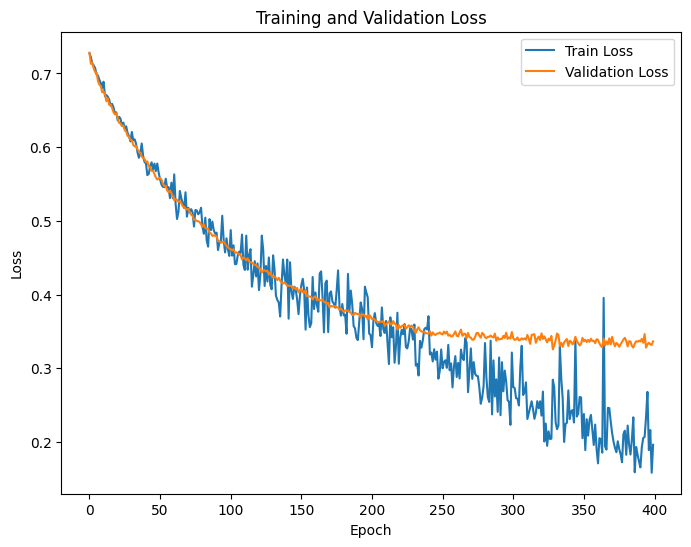

In [14]:
# 从文件中读取数据并画图
train_losses = []
val_losses = []
with open('loss_data.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        train_loss, val_loss = map(float, line.strip().split('\t'))
        train_losses.append(train_loss)
        val_losses.append(val_loss)

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/loss.png')
plt.show()

In [15]:
import os
import zipfile
import datetime

def file2zip(packagePath, zipPath):
    '''
  :param packagePath: 文件夹路径
  :param zipPath: 压缩包路径
  :return:
  '''
    zip = zipfile.ZipFile(zipPath, 'w', zipfile.ZIP_DEFLATED)
    for path, dirNames, fileNames in os.walk(packagePath):
        fpath = path.replace(packagePath, '')
        for name in fileNames:
            fullName = os.path.join(path, name)
            name = fpath + '\\' + name
            zip.write(fullName, name)
    zip.close()


if __name__ == "__main__":
    # 文件夹路径
    packagePath = '/kaggle/working/train_images'
    zipPath = '/kaggle/working/train_images.zip'
    if os.path.exists(zipPath):
        os.remove(zipPath)
    file2zip(packagePath, zipPath)
    print("打包完成")
    print(datetime.datetime.utcnow())

打包完成
2024-09-13 09:33:07.852960
